<a href="https://colab.research.google.com/github/Kanchan786786/Capstone_project-/blob/main/snapchat_LStm_Arima_sarima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner --upgrade


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import BayesianOptimization

<ipython-input-2-d292747a5cab>:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [3]:
pip install yfinance


In [4]:
!pip install ta


In [5]:
# # Install required libraries
# # !pip install yfinance pandas ta

# import yfinance as yf
# import pandas as pd
# from ta.trend import sma_indicator, ema_indicator, MACD
# from ta.momentum import RSIIndicator

# # Define Snapchat ticker symbol
# symbol = 'SNAP'

# # Set time period for data retrieval
# start_date = '2019-03-29'
# end_date = '2024-12-31'

# # Download data with auto_adjust=True by default
# snap_data = yf.download(symbol, start=start_date, end=end_date)

# # Calculate VWAP
# snap_data['VWAP'] = (snap_data['Volume'] * (snap_data['High'] + snap_data['Low'] + snap_data['Close']) / 3).cumsum() / snap_data['Volume'].cumsum()

# # Extract close series
# close_series = snap_data['Close'].squeeze()

# # Add technical indicators
# snap_data['SMA_50'] = sma_indicator(close_series, window=50)
# snap_data['EMA_50'] = ema_indicator(close_series, window=50)
# snap_data['RSI'] = RSIIndicator(close_series).rsi()
# macd = MACD(close_series)
# snap_data['MACD'] = macd.macd()
# snap_data['MACD_Signal'] = macd.macd_signal()
# snap_data['MACD_Hist'] = macd.macd_diff()

# # Use Close as proxy for Adjusted Close since auto_adjust=True by default
# snap_data['Adjusted_Close'] = snap_data['Close']

# # Market Cap approximation (close price * volume)
# snap_data['Market_Cap'] = snap_data['Close'] * snap_data['Volume']

# # Create Tomorrow's Close feature
# snap_data['Tomorrow'] = snap_data['Close'].shift(-1)

# # Select required features
# desired_features = ['Close', 'Tomorrow', 'Low', 'Open', 'Volume', 'VWAP', 'Adjusted_Close', 'Market_Cap', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'High']
# snap_data = snap_data[desired_features].dropna()

# # Reset index for convenience
# snap_data.reset_index(inplace=True)

# # Display the first few rows of the dataset
# print(snap_data.head())

# # Save the dataset to a CSV file
# snap_data.to_csv('snapchat_stock_data_features.csv', index=False)

In [6]:
url = 'https://raw.githubusercontent.com/Kanchan786786/Capstone_project-/main/snapchat_stock_data_features.csv'
df = pd.read_csv(url)

In [7]:
df.head()

,Date,Close,Tomorrow,Low,Open,Volume,VWAP,Adjusted_Close,Market_Cap,SMA_50,EMA_50,RSI,MACD,MACD_Signal,MACD_Hist,High
0,2019-06-10,13.77,13.54,13.695,13.95,25589800,11.725121,13.77,352371557.7,11.6144,11.716234,72.124297,0.607705,0.335428,0.272277,14.07
1,2019-06-11,13.54,13.75,13.385,13.93,21898000,11.754604,13.54,296498919.2,11.6648,11.787754,68.106898,0.631566,0.394656,0.236910,13.97
2,2019-06-12,13.75,14.11,13.477,13.71,17515800,11.778810,13.75,240842250.0,11.7126,11.864705,69.762965,0.659815,0.447688,0.212127,13.98
3,2019-06-13,14.11,13.96,13.750,13.85,25003000,11.817858,14.11,352792321.4,11.7704,11.952756,72.408001,0.703146,0.498779,0.204367,14.31
4,2019-06-14,13.96,13.55,13.650,14.15,24189700,11.852153,13.96,337688212.9,11.8264,12.031471,69.673169,0.717116,0.542447,0.174669,14.15


In [8]:
# prompt: drop the first row

df = df.iloc[1:]
df.tail()


,Date,Close,Tomorrow,Low,Open,Volume,VWAP,Adjusted_Close,Market_Cap,SMA_50,EMA_50,RSI,MACD,MACD_Signal,MACD_Hist,High
1394,2024-12-20,11.40,11.26,10.95,11.010,38555400,21.990073,11.40,4.395315e+08,11.3976,11.416961,47.183399,-0.018725,0.101022,-0.119747,11.63
1395,2024-12-23,11.26,11.18,11.00,11.525,37248300,21.980764,11.26,4.194159e+08,11.4002,11.410805,44.976320,-0.040313,0.072755,-0.113068,11.59
1396,2024-12-24,11.18,11.20,11.12,11.270,7892400,21.978777,11.18,8.823703e+07,11.4028,11.401754,43.717870,-0.063149,0.045574,-0.108723,11.28
1397,2024-12-26,11.20,10.99,11.07,11.110,12813800,21.975560,11.20,1.435146e+08,11.4060,11.393842,44.138672,-0.078725,0.020714,-0.099439,11.38
1398,2024-12-27,10.99,10.86,10.77,11.160,22670500,21.969747,10.99,2.491488e+08,11.4106,11.378005,40.697841,-0.106784,-0.004785,-0.101998,11.18


In [9]:
# prompt: see the missing values

print(df.isnull().sum())


Date              0
Close             0
Tomorrow          0
Low               0
Open              0
Volume            0
VWAP              0
Adjusted_Close    0
Market_Cap        0
SMA_50            0
EMA_50            0
RSI               0
MACD              0
MACD_Signal       0
MACD_Hist         0
High              0
dtype: int64


In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Select features and target variable
features = ['High', 'Low', 'Open', 'Volume', 'VWAP', 'Adjusted_Close', 'Market_Cap', 'SMA_50', 'EMA_50', 'RSI', 'MACD']
target = 'Close'

# Normalize data using MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features + [target]]), columns=features + [target], index=df.index)

# Prepare sequences for LSTM
def create_sequences(data, feature_cols, target_col, time_steps=60):
    np.random.seed(42)
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[feature_cols].iloc[i:i+time_steps].values)
        y.append(data[target_col].iloc[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 60  # Use past 60 days for prediction
X, y = create_sequences(df_scaled, features, target, time_steps)

from sklearn.model_selection import train_test_split

# Step 1: First split into temp (85%) and test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, shuffle=False, random_state=42)

# Step 2: Split temp into train (70%) and validation (15%)
# Note: 15% / 85% ≈ 0.1765 — so we split 17.65% from temp to get 15% of total as val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, shuffle=False, random_state=42)


# # Build the LSTM model
# model = Sequential([
#     LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dropout(0.2),
#     LSTM(50, return_sequences=False),
#     Dropout(0.2),
#     Dense(25, activation='relu'),
#     Dense(1)
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# # Make predictions
# predictions = model.predict(X_test)

# # Inverse transform the predictions to the original scale
# predictions_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], predictions.reshape(-1, 1)), axis=1))[:, -1]
# y_test_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]



In [11]:
X_train.shape, X_val.shape, X_test.shape

((936, 60, 11), (201, 60, 11), (201, 60, 11))

In [12]:
# # prompt: plot a graph little clear with the advance and clear details , x axis dates should be claer like it shiuld not over lap

# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# # ... (Your existing code)

# # Plot actual vs predicted values
# plt.figure(figsize=(12, 6))

# # Convert 'Date' column to datetime objects
# df['Date'] = pd.to_datetime(df['Date'])

# plt.plot(df['Date'].iloc[-len(y_test):], y_test_inv, label="Actual Prices")
# plt.plot(df['Date'].iloc[-len(y_test):], predictions_inv, label="Predicted Prices", linestyle='dashed')
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.title("Actual vs Predicted Prices")

# # Format the x-axis for better date display
# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Customize the date format as needed
# plt.gcf().autofmt_xdate() # Rotate date labels for better readability

# plt.tight_layout() # Adjust layout to prevent labels from overlapping
# plt.show()


In [13]:
!pip install keras-tuner


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch

# Define the model function for tuning
def build_model(hp):
    model = Sequential([
        LSTM(hp.Int('units1', min_value=50, max_value=200, step=50), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])),
        LSTM(hp.Int('units2', min_value=50, max_value=200, step=50), return_sequences=False),
        Dropout(hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])),
        Dense(25, activation=hp.Choice('activation', ['relu', 'tanh'])),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials= 5,  # Number of different models to try
    executions_per_trial=1,  # Number of times to train each model
    directory='lstm_tuner',
    project_name='stock_prediction'
)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate
best_model.evaluate(X_test, y_test)


Reloading Tuner from lstm_tuner/stock_prediction/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 688ms/step - loss: 0.0407 - val_loss: 5.7494e-04
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 591ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 582ms/step - loss: 0.0037 - val_loss: 3.2522e-04
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 311ms/step - loss: 0.0033 - val_loss: 1.4007e-04
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - loss: 0.0025 - val_loss: 2.0794e-04
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - loss: 0.0032 - val_loss: 1.8757e-04
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - loss: 0.0035 - val_loss: 2.4409e-04
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - loss: 0.0023 - val_loss: 1.6186e-04
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - loss: 0.0023 - val_loss: 1.8309e-04
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 437ms/step - loss: 0.0022 - val_loss: 2.2388e-04
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 328ms/step - loss: 0.0027 - val_loss: 3.6731e-04
Epo

0.00011269291280768812

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score



In [17]:
import numpy as np
# # Evaluate the model on the training data
# train_predictions =best_model.predict(X_train)
# train_predictions_inv = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], train_predictions.reshape(-1, 1)), axis=1))[:, -1]
# y_train_inv = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]
# For test data
test_predictions =best_model.predict(X_test)
y_test_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]
predictions_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], test_predictions.reshape(-1, 1)), axis=1))[:, -1]

# train_mse = mean_squared_error(y_train_inv, train_predictions_inv)
# train_rmse = np.sqrt(train_mse)
# train_r2 = r2_score(y_train_inv, train_predictions_inv)

# print(f"Training Accuracy (R-squared): {train_r2}")
# print(f"Training MSE: {train_mse}")
# print(f"Training RMSE: {train_rmse}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 470ms/step


In [18]:
import matplotlib.dates as mdates


In [19]:
import pandas as pd

# Assuming your date column is named 'Date'
df['Date'] = pd.to_datetime(df['Date'])


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step

Evaluation Metrics for Best Model:

                           Metric     Value
0        Mean Squared Error (MSE)  0.639828
1  Root Mean Squared Error (RMSE)  0.799892
2                  R-squared (R2)  0.897557

Best Model - Testing Accuracy (R-squared): 0.8975571393564219
Best Model - Testing MSE: 0.6398278678968473
Best Model - Testing RMSE: 0.7998924102008015


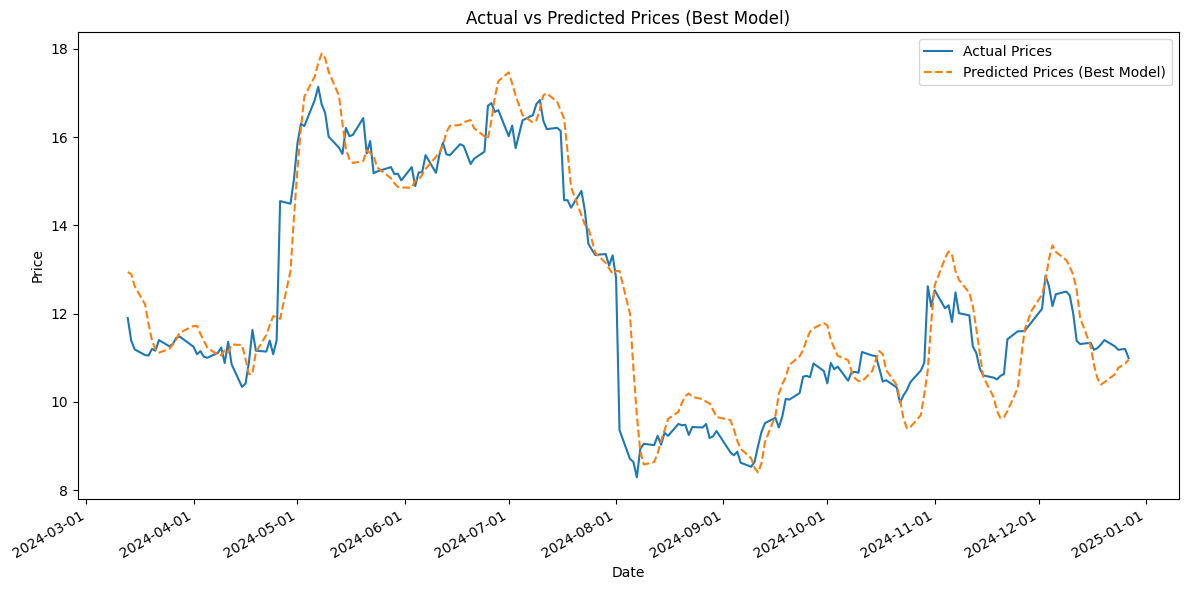

In [20]:
# prompt: generate the code the error metric just like model2 for my best model as well

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Make predictions with the best model
best_predictions = best_model.predict(X_test)

# Inverse transform the predictions to the original scale
best_predictions_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], best_predictions.reshape(-1, 1)), axis=1))[:, -1]

# Calculate evaluation metrics for the best model
best_mse = mean_squared_error(y_test_inv, best_predictions_inv)
best_rmse = np.sqrt(best_mse)
best_r2 = r2_score(y_test_inv, best_predictions_inv)

# Create a table of evaluation metrics for the best model
best_evaluation_metrics = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'R-squared (R2)'],
    'Value': [best_mse, best_rmse, best_r2]
})

print("\nEvaluation Metrics for Best Model:\n")
print(best_evaluation_metrics)

# # Evaluate the best model on the training data
# best_train_predictions = best_model.predict(X_train)
# best_train_predictions_inv = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], best_train_predictions.reshape(-1, 1)), axis=1))[:, -1]

# best_train_mse = mean_squared_error(y_train_inv, best_train_predictions_inv)
# best_train_rmse = np.sqrt(best_train_mse)
# best_train_r2 = r2_score(y_train_inv, best_train_predictions_inv)

# print(f"\nBest Model - Training Accuracy (R-squared): {best_train_r2}")
# print(f"Best Model - Training MSE: {best_train_mse}")
# print(f"Best Model - Training RMSE: {best_train_rmse}")

print(f"\nBest Model - Testing Accuracy (R-squared): {best_r2}")
print(f"Best Model - Testing MSE: {best_mse}")
print(f"Best Model - Testing RMSE: {best_rmse}")

#Plot for the best model
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-len(y_test):], y_test_inv, label="Actual Prices")
plt.plot(df['Date'].iloc[-len(y_test):], best_predictions_inv, label="Predicted Prices (Best Model)", linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.title("Actual vs Predicted Prices (Best Model)")
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


In [21]:
# Model builder for KerasTuner
from tensorflow.keras.optimizers import Adam, RMSprop

In [22]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 3)):
        return_sequences = i < hp.get('num_layers') - 1
        model.add(LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
                       return_sequences=return_sequences,
                       input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(loss='mse', optimizer=Adam(learning_rate=lr) if optimizer=='adam' else RMSprop(learning_rate=lr))
    return model

In [23]:
# Tuner setup
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials= 8,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='stock_lstm')

Reloading Tuner from lstm_tuning/stock_lstm/tuner0.json


In [24]:
# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5)

In [25]:
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[early_stop, reduce_lr])

In [26]:
# Get best model
best_model_2 = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 7 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [27]:
model = build_model(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters)
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2,
          callbacks=[early_stop, reduce_lr])

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - loss: 0.1214 - val_loss: 9.3856e-04 - learning_rate: 5.1128e-04
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0114 - val_loss: 0.0023 - learning_rate: 5.1128e-04
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0087 - val_loss: 1.8739e-04 - learning_rate: 5.1128e-04
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0113 - val_loss: 3.3442e-04 - learning_rate: 5.1128e-04
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0060 - val_loss: 6.3910e-04 - learning_rate: 5.1128e-04
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.0061 - val_loss: 1.9667e-04 - learning_rate: 5.1128e-04
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0041 - val_loss: 0.0011 - learning_rate: 2.5564e-04
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0050 - val_loss: 5.4541e-04 - learning_rate: 2.5564e-04


In [28]:
preds_2 = model.predict(X_val)
mse_2 = mean_squared_error(y_val, preds_2)
print("Test MSE:", mse_2)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step
Test MSE: 0.0008517678555637233


In [29]:
# Evaluate
preds = model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print("Test MSE:", mse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Test MSE: 0.0010096185030729734


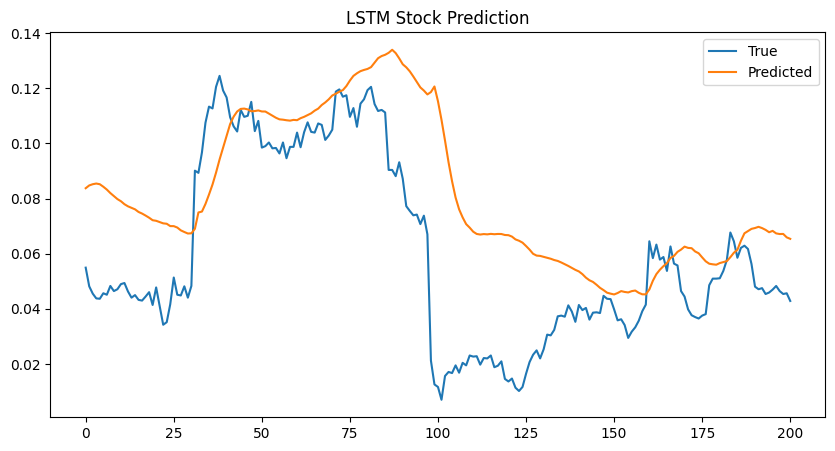

In [30]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(y_test, label='True')
plt.plot(preds, label='Predicted')
plt.legend()
plt.title('LSTM Stock Prediction')
plt.show()


In [31]:
from sklearn.metrics import r2_score

# # Training R-squared
# train_preds = model.predict(X_train)
# train_r2 = r2_score(y_train, train_preds)
# print(f"Training R-squared: {train_r2}")


test_r2 = r2_score(y_test, preds)
print(f"Testing R-squared: {test_r2}")

Testing R-squared: 0.0822120228214901


In [32]:
from sklearn.metrics import r2_score

# # Training R-squared
# train_preds = model.predict(X_train)
# train_r2 = r2_score(y_train, train_preds)
# print(f"Training R-squared: {train_r2}")


val_r2 = r2_score(y_val, preds_2)
print(f"Validation R-squared: {val_r2}")

Validation R-squared: 0.32228262029047894


## Sarima And Arima

In [33]:
import pandas as pd

url = 'https://raw.githubusercontent.com/Kanchan786786/Capstone_project-/main/snapchat_stock_data_features.csv'
df_arima = pd.read_csv(url)

# Preview the data
df_arima.head()


,Date,Close,Tomorrow,Low,Open,Volume,VWAP,Adjusted_Close,Market_Cap,SMA_50,EMA_50,RSI,MACD,MACD_Signal,MACD_Hist,High
0,2019-06-10,13.77,13.54,13.695,13.95,25589800,11.725121,13.77,352371557.7,11.6144,11.716234,72.124297,0.607705,0.335428,0.272277,14.07
1,2019-06-11,13.54,13.75,13.385,13.93,21898000,11.754604,13.54,296498919.2,11.6648,11.787754,68.106898,0.631566,0.394656,0.236910,13.97
2,2019-06-12,13.75,14.11,13.477,13.71,17515800,11.778810,13.75,240842250.0,11.7126,11.864705,69.762965,0.659815,0.447688,0.212127,13.98
3,2019-06-13,14.11,13.96,13.750,13.85,25003000,11.817858,14.11,352792321.4,11.7704,11.952756,72.408001,0.703146,0.498779,0.204367,14.31
4,2019-06-14,13.96,13.55,13.650,14.15,24189700,11.852153,13.96,337688212.9,11.8264,12.031471,69.673169,0.717116,0.542447,0.174669,14.15


In [34]:
df_info = df_arima.info()
df_head = df_arima.head()
df_describe = df_arima.describe()

df_head, df_info, df_describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1399 non-null   object 
 1   Close           1399 non-null   float64
 2   Tomorrow        1399 non-null   float64
 3   Low             1399 non-null   float64
 4   Open            1399 non-null   float64
 5   Volume          1399 non-null   int64  
 6   VWAP            1399 non-null   float64
 7   Adjusted_Close  1399 non-null   float64
 8   Market_Cap      1399 non-null   float64
 9   SMA_50          1399 non-null   float64
 10  EMA_50          1399 non-null   float64
 11  RSI             1399 non-null   float64
 12  MACD            1399 non-null   float64
 13  MACD_Signal     1399 non-null   float64
 14  MACD_Hist       1399 non-null   float64
 15  High            1399 non-null   float64
dtypes: float64(14), int64(1), object(1)
memory usage: 175.0+ KB


(         Date  Close  Tomorrow     Low   Open    Volume       VWAP  \
 0  2019-06-10  13.77     13.54  13.695  13.95  25589800  11.725121   
 1  2019-06-11  13.54     13.75  13.385  13.93  21898000  11.754604   
 2  2019-06-12  13.75     14.11  13.477  13.71  17515800  11.778810   
 3  2019-06-13  14.11     13.96  13.750  13.85  25003000  11.817858   
 4  2019-06-14  13.96     13.55  13.650  14.15  24189700  11.852153   
 
    Adjusted_Close   Market_Cap   SMA_50     EMA_50        RSI      MACD  \
 0           13.77  352371557.7  11.6144  11.716234  72.124297  0.607705   
 1           13.54  296498919.2  11.6648  11.787754  68.106898  0.631566   
 2           13.75  240842250.0  11.7126  11.864705  69.762965  0.659815   
 3           14.11  352792321.4  11.7704  11.952756  72.408001  0.703146   
 4           13.96  337688212.9  11.8264  12.031471  69.673169  0.717116   
 
    MACD_Signal  MACD_Hist   High  
 0     0.335428   0.272277  14.07  
 1     0.394656   0.236910  13.97  
 2    

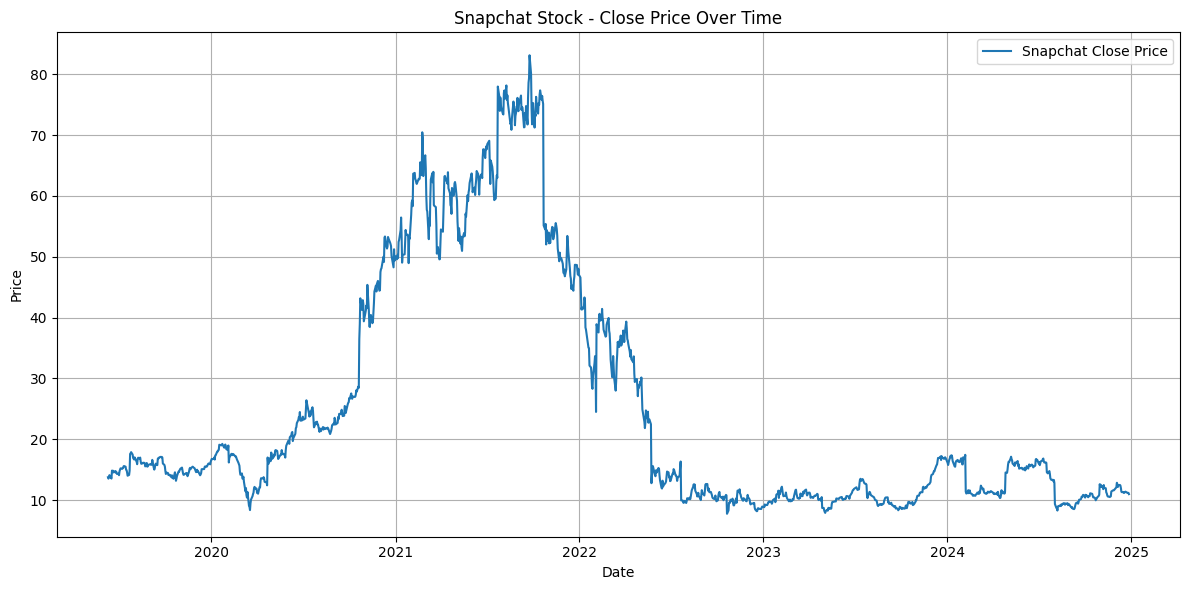

{'ADF Statistic': np.float64(-1.258748850019262),
 'p-value': np.float64(0.6478272538466985),
 'Used Lag': 1,
 'Number of Observations': 1397,
 'Critical Values': {'1%': np.float64(-3.4350395894411734),
  '5%': np.float64(-2.863611117606763),
  '10%': np.float64(-2.5678726562185354)},
 'Stationary?': 'No'}

In [35]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Step 1: Convert Date to datetime and set as index
df_arima['Date'] = pd.to_datetime(df_arima['Date'])
df_arima.set_index('Date', inplace=True)

# Step 2: Extract the target time series (we'll use 'Close' for now)
ts = df_arima['Close']

# Step 3: Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Snapchat Close Price')
plt.title('Snapchat Stock - Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Perform Augmented Dickey-Fuller test
adf_result = adfuller(ts)

adf_summary = {
    'ADF Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Used Lag': adf_result[2],
    'Number of Observations': adf_result[3],
    'Critical Values': adf_result[4],
    'Stationary?': 'Yes' if adf_result[1] < 0.05 else 'No'
}

adf_summary


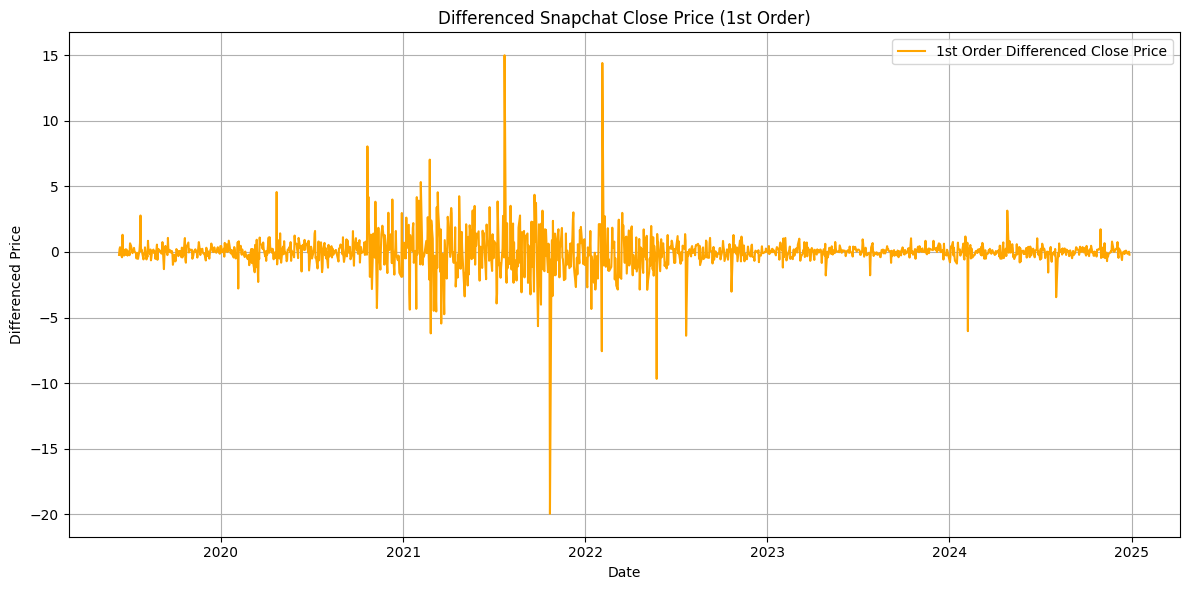

{'ADF Statistic': np.float64(-39.156498756823986),
 'p-value': 0.0,
 'Used Lag': 0,
 'Number of Observations': 1397,
 'Critical Values': {'1%': np.float64(-3.4350395894411734),
  '5%': np.float64(-2.863611117606763),
  '10%': np.float64(-2.5678726562185354)},
 'Stationary?': 'Yes'}

In [36]:
# Step 5: First-order differencing to make the series stationary
ts_diff = ts.diff().dropna()

# Plot differenced series
plt.figure(figsize=(12, 6))
plt.plot(ts_diff, label='1st Order Differenced Close Price', color='orange')
plt.title('Differenced Snapchat Close Price (1st Order)')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ADF test on differenced series
adf_diff_result = adfuller(ts_diff)

adf_diff_summary = {
    'ADF Statistic': adf_diff_result[0],
    'p-value': adf_diff_result[1],
    'Used Lag': adf_diff_result[2],
    'Number of Observations': adf_diff_result[3],
    'Critical Values': adf_diff_result[4],
    'Stationary?': 'Yes' if adf_diff_result[1] < 0.05 else 'No'
}

adf_diff_summary


In [37]:
# Split data: 85% train, 15% test (chronologically)
split_index = int(len(ts) * 0.85)
ts_train = ts.iloc[:split_index]
ts_test = ts.iloc[split_index:]

# Confirm the split sizes
train_len = len(ts_train)
test_len = len(ts_test)

train_len, test_len, ts_train.tail(), ts_test.head()


(1189,
 210,
 Date
 2024-02-22    10.73
 2024-02-23    10.80
 2024-02-26    10.72
 2024-02-27    10.90
 2024-02-28    11.00
 Name: Close, dtype: float64,
 Date
 2024-02-29    11.02
 2024-03-01    11.25
 2024-03-04    11.03
 2024-03-05    11.43
 2024-03-06    11.16
 Name: Close, dtype: float64)

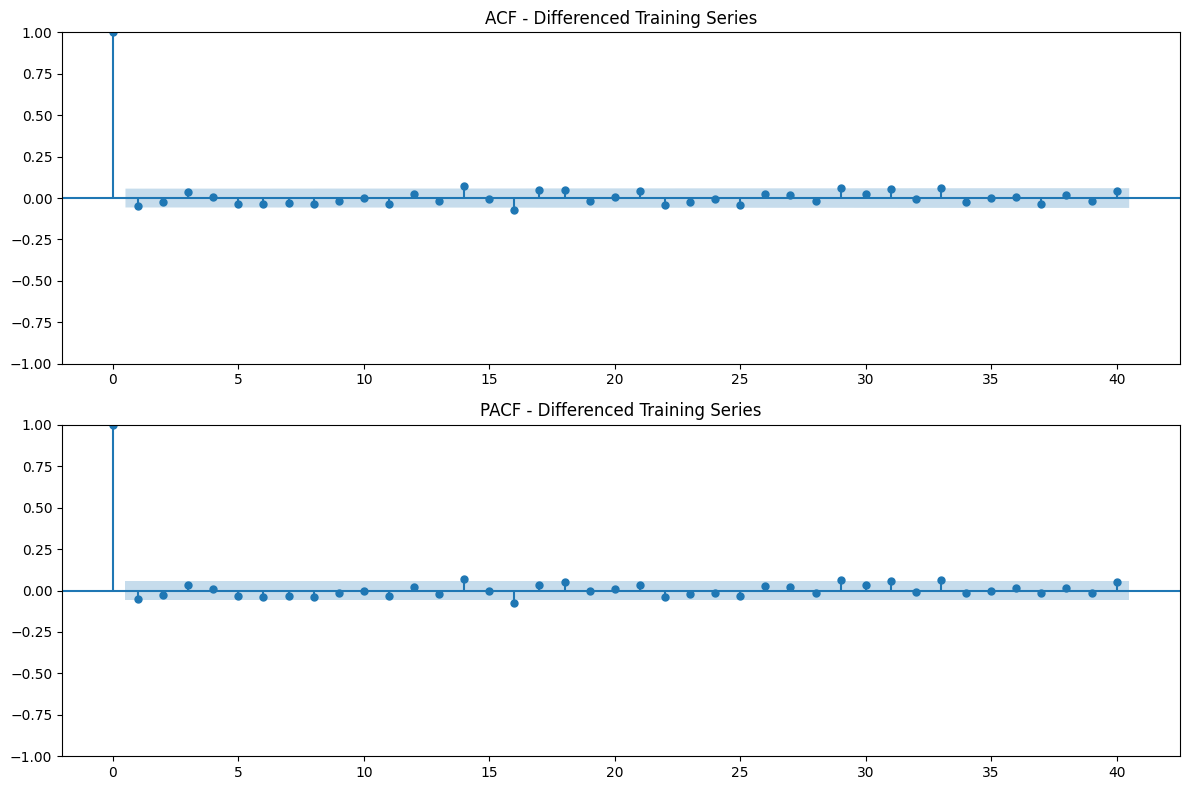

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use differenced training data for ACF/PACF
ts_train_diff = ts_train.diff().dropna()

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(ts_train_diff, lags=40, ax=ax[0])
ax[0].set_title('ACF - Differenced Training Series')

plot_pacf(ts_train_diff, lags=40, ax=ax[1])
ax[1].set_title('PACF - Differenced Training Series')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

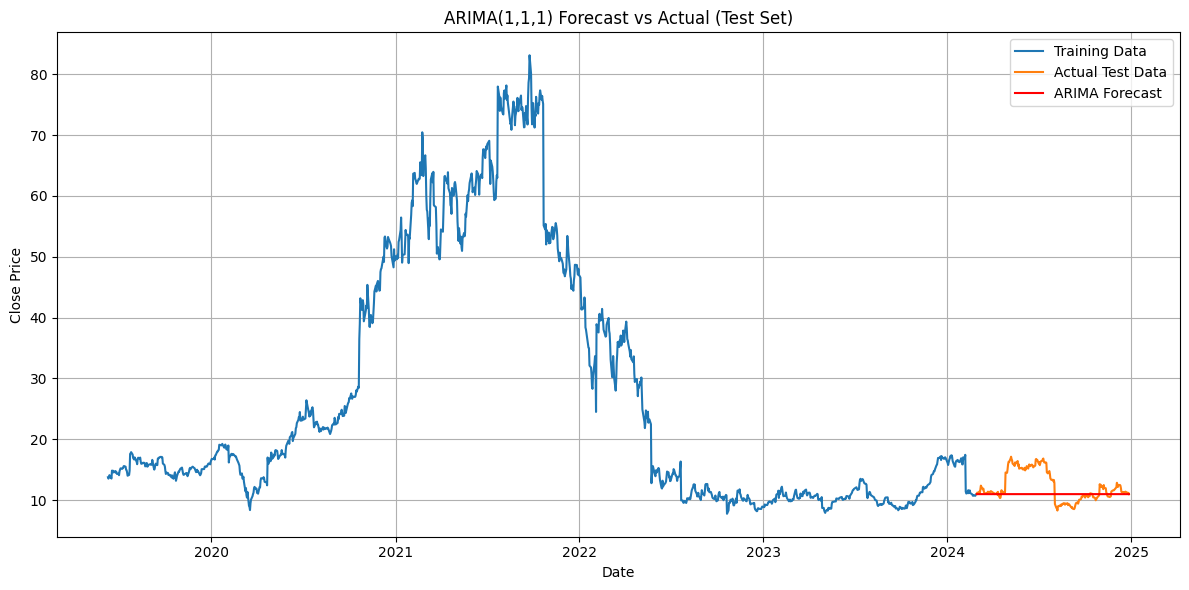

(7.602211018190757, 2.000167760125114)

In [39]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(1,1,1) on training data
arima_model = ARIMA(ts_train, order=(1, 1, 1))
arima_result = arima_model.fit()

# Forecast for the same length as test set
arima_forecast = arima_result.forecast(steps=len(ts_test))

# Plot actual vs forecasted
plt.figure(figsize=(12, 6))
plt.plot(ts_train, label='Training Data')
plt.plot(ts_test, label='Actual Test Data')
plt.plot(ts_test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA(1,1,1) Forecast vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_arima = mean_squared_error(ts_test, arima_forecast)
mae_arima = mean_absolute_error(ts_test, arima_forecast)

mse_arima, mae_arima


In [40]:
from sklearn.metrics import r2_score

# Calculate R² score for ARIMA predictions
r2_arima = r2_score(ts_test, arima_forecast)

r2_arima


-0.2649628990599746

In [41]:
!pip install pmdarima


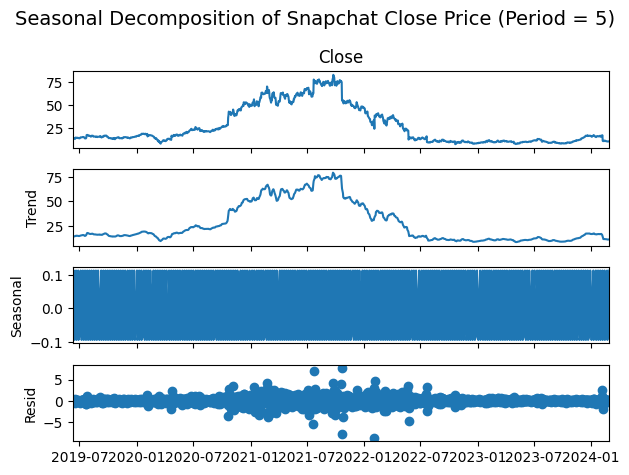

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Apply seasonal decomposition on training set (assuming daily frequency)
decomposition = seasonal_decompose(ts_train, model='additive', period=5)  # 5 = weekly pattern

# Plot the decomposition
decomposition.plot()
plt.suptitle("Seasonal Decomposition of Snapchat Close Price (Period = 5)", fontsize=14)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


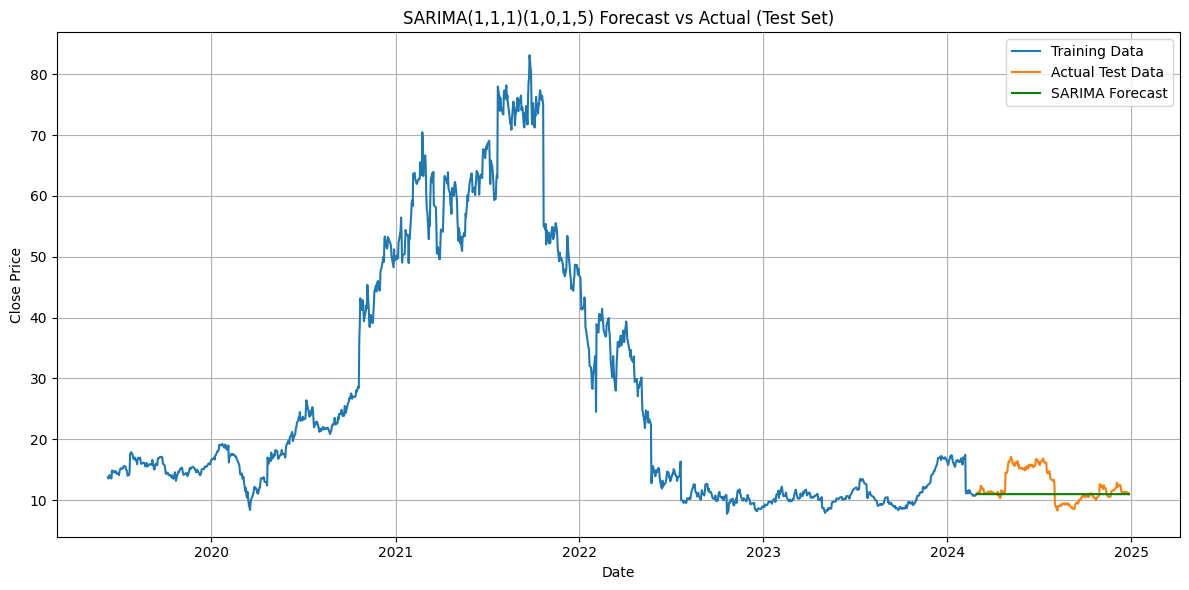

(7.611374386634903, 2.001246710743244)

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA(1,1,1)(1,0,1,5)
sarima_model = SARIMAX(ts_train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 5))
sarima_result = sarima_model.fit(disp=False)

# Forecast for the length of the test set
sarima_forecast = sarima_result.forecast(steps=len(ts_test))

# Plot actual vs forecasted
plt.figure(figsize=(12, 6))
plt.plot(ts_train, label='Training Data')
plt.plot(ts_test, label='Actual Test Data')
plt.plot(ts_test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.title('SARIMA(1,1,1)(1,0,1,5) Forecast vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate performance
mse_sarima = mean_squared_error(ts_test, sarima_forecast)
mae_sarima = mean_absolute_error(ts_test, sarima_forecast)

mse_sarima, mae_sarima


In [44]:
from sklearn.metrics import r2_score

# Calculate R² score for ARIMA predictions
r2_sarima = r2_score(ts_test, sarima_forecast)

r2_sarima


-0.26648762931075654

### Log and Scale to transform the dataset and try again the Arima and Sarima to see the trend

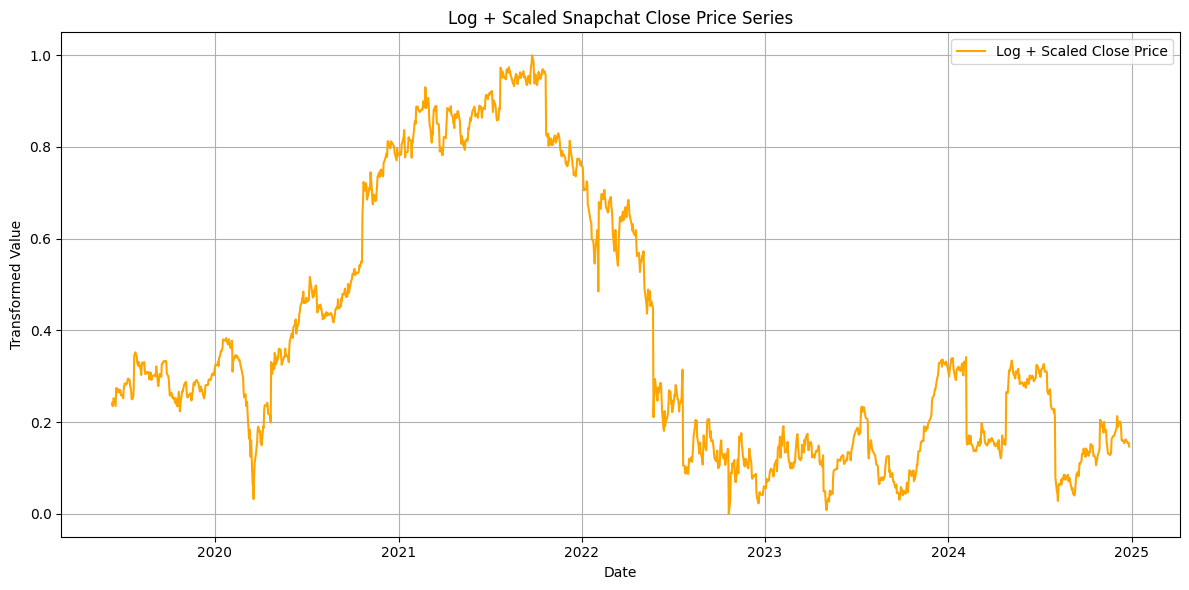

(Date
 2019-06-10    0.241867
 2019-06-11    0.234763
 2019-06-12    0.241254
 2019-06-13    0.252153
 2019-06-14    0.247646
 dtype: float64,
 Date
 2024-02-29    0.147913
 2024-03-01    0.156625
 2024-03-04    0.148296
 2024-03-05    0.163319
 2024-03-06    0.153237
 dtype: float64)

In [45]:
# Load the re-uploaded dataset
file_path = "https://raw.githubusercontent.com/Kanchan786786/Capstone_project-/main/snapchat_stock_data_features.csv"
df = pd.read_csv(file_path)

# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Extract target time series
ts = df['Close']

# Step 1: Log transformation
ts_log = np.log(ts)

# Step 2: MinMax scaling
scaler = MinMaxScaler(feature_range=(0, 1))
ts_log_scaled = pd.Series(
    scaler.fit_transform(ts_log.values.reshape(-1, 1)).flatten(),
    index=ts.index
)

# Step 3: Split into training and testing (85/15)
split_index = int(len(ts_log_scaled) * 0.85)
ts_train_scaled = ts_log_scaled.iloc[:split_index]
ts_test_scaled = ts_log_scaled.iloc[split_index:]

# Plot transformed series
plt.figure(figsize=(12, 6))
plt.plot(ts_log_scaled, label='Log + Scaled Close Price', color='orange')
plt.title('Log + Scaled Snapchat Close Price Series')
plt.xlabel('Date')
plt.ylabel('Transformed Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ts_train_scaled.head(), ts_test_scaled.head()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

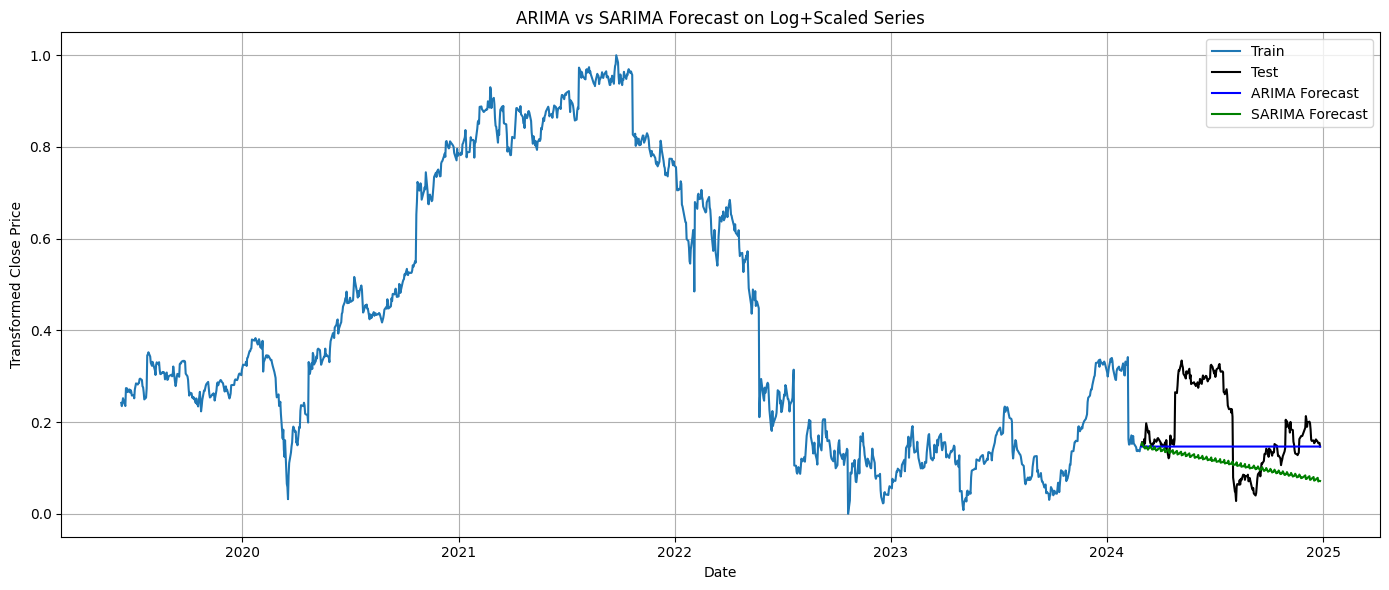

({'MSE': 0.008213868048690356,
  'MAE': 0.06845015508208704,
  'R²': -0.2113677725756391},
 {'MSE': 0.011622376692937838,
  'MAE': 0.0857372218782244,
  'R²': -0.7140490306274061})

In [46]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ARIMA model (1,1,1) on log+scaled data
arima_model = ARIMA(ts_train_scaled, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(ts_test_scaled))

# SARIMA model (1,1,1)(1,1,0,5) as a starting config
sarima_model = SARIMAX(ts_train_scaled, order=(1, 1, 1), seasonal_order=(1, 1, 0, 5))
sarima_result = sarima_model.fit(disp=False)
sarima_forecast = sarima_result.forecast(steps=len(ts_test_scaled))

# Evaluate both models
def evaluate(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred)
    }

arima_metrics = evaluate(ts_test_scaled, arima_forecast)
sarima_metrics = evaluate(ts_test_scaled, sarima_forecast)

# Plot forecasts
plt.figure(figsize=(14, 6))
plt.plot(ts_train_scaled, label='Train')
plt.plot(ts_test_scaled, label='Test', color='black')
plt.plot(ts_test_scaled.index, arima_forecast, label='ARIMA Forecast', color='blue')
plt.plot(ts_test_scaled.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.title("ARIMA vs SARIMA Forecast on Log+Scaled Series")
plt.xlabel("Date")
plt.ylabel("Transformed Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

arima_metrics, sarima_metrics


ARIMA outperformed SARIMA on all metrics (lower error, higher R² — though still negative)

 SARIMA is overfitting or using ineffective seasonality
 R² is still negative for both: this means neither model is generalizing well yet (probably due to noise or nonlinearity)




### Prophet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1399 non-null   object 
 1   Close           1399 non-null   float64
 2   Tomorrow        1399 non-null   float64
 3   Low             1399 non-null   float64
 4   Open            1399 non-null   float64
 5   Volume          1399 non-null   int64  
 6   VWAP            1399 non-null   float64
 7   Adjusted_Close  1399 non-null   float64
 8   Market_Cap      1399 non-null   float64
 9   SMA_50          1399 non-null   float64
 10  EMA_50          1399 non-null   float64
 11  RSI             1399 non-null   float64
 12  MACD            1399 non-null   float64
 13  MACD_Signal     1399 non-null   float64
 14  MACD_Hist       1399 non-null   float64
 15  High            1399 non-null   float64
dtypes: float64(14), int64(1), object(1)
memory usage: 175.0+ KB


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/9dcbbbx0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/jbs3la75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59', 'data', 'file=/tmp/tmpbruor5yw/9dcbbbx0.json', 'init=/tmp/tmpbruor5yw/jbs3la75.json', 'output', 'file=/tmp/tmpbruor5yw/prophet_model8iasalz1/prophet_model-20250411020411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:04:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:04:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Validation R-squared: -1.7892
Validation MSE: 4.7586
Testing R-squared: -4.4094
Testing MSE: 37.8577


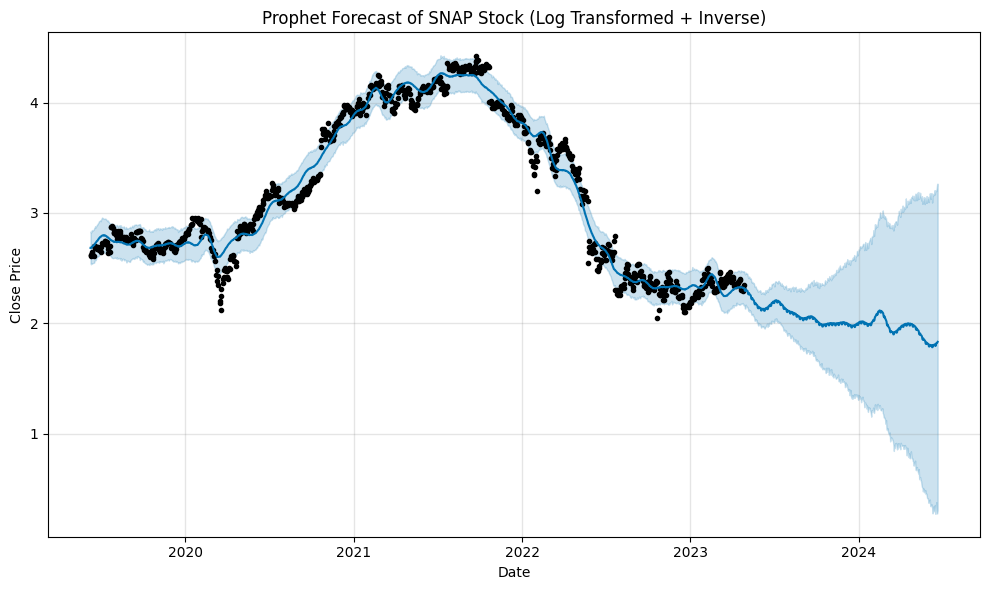

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/14q021ok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/xw8fh647.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89352', 'data', 'file=/tmp/tmpbruor5yw/14q021ok.json', 'init=/tmp/tmpbruor5yw/xw8fh647.json', 'output', 'file=/tmp/tmpbruor5yw/prophet_modelvepx7dkg/prophet_model-20250411020413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:04:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:04:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Validation R-squared: -2.0945
Validation MSE: 5.5377
Testing R-squared: -4.9700
Testing MSE: 42.6065


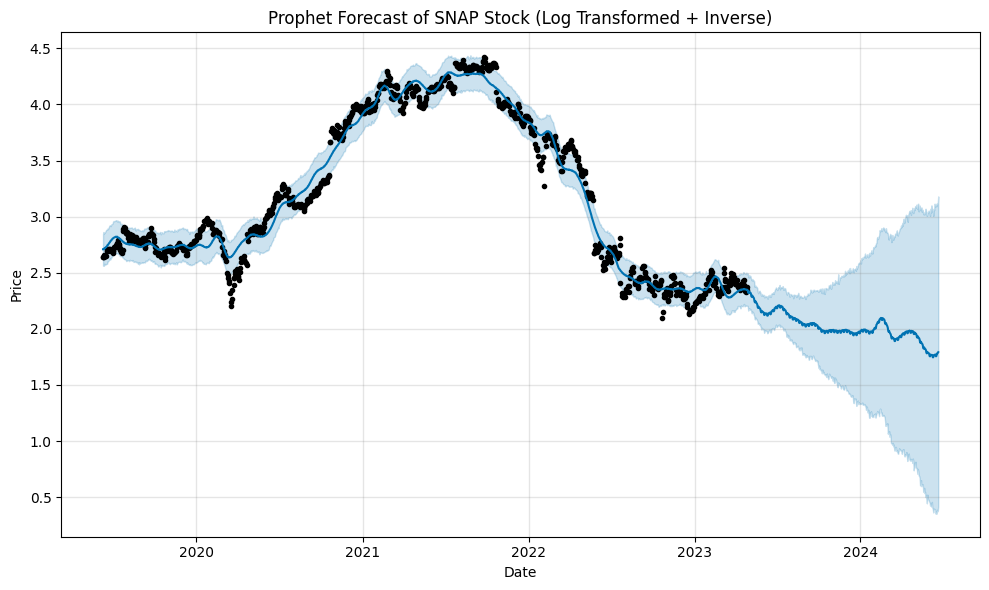

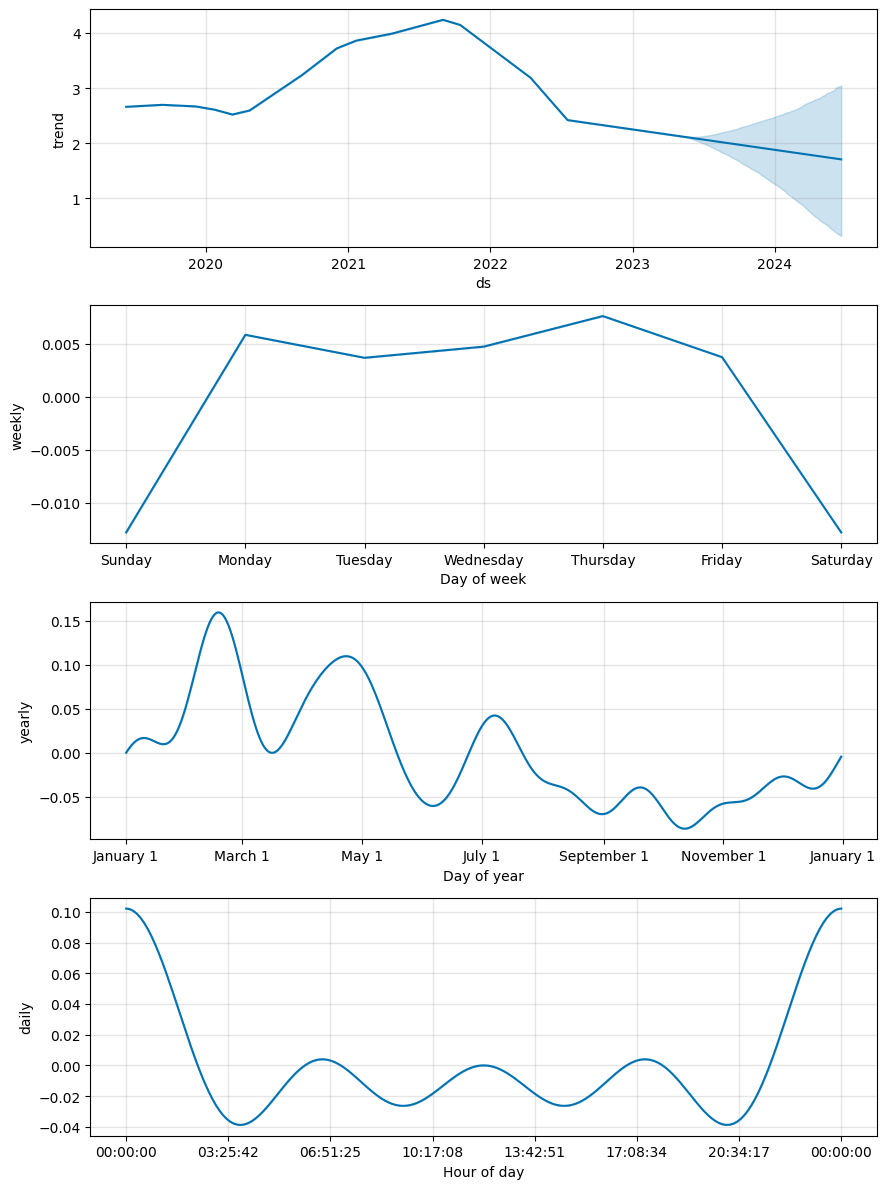

In [47]:
!pip install prophet

import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

snap=pd.read_csv(r'https://github.com/Kanchan786786/Capstone_project-/raw/main/snapchat_stock_data_features.csv')
snap.head()

snap.info()

import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Prepare the DataFrame for Prophet with log-transformed 'y'
df = snap[['Date', 'Close']].copy()
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])

# Log-transform the target
df['y'] = np.log(df['y'])

# Step 2: Split into train (70%), validation (10%), test (20%)
n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.8)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

# Step 3: Train the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(train_df)

# Step 4: Create future dataframe and forecast
future = model.make_future_dataframe(periods=len(val_df) + len(test_df), freq='D')
forecast = model.predict(future)

# Step 5: Split forecast for validation and testing
forecast_val = forecast.iloc[train_end:val_end][['ds', 'yhat']].set_index('ds')
forecast_test = forecast.iloc[val_end:][['ds', 'yhat']].set_index('ds')

# Prepare actuals
actual_val = val_df.set_index('ds')
actual_test = test_df.set_index('ds')

# Step 6: Inverse log to get original scale
forecast_val['yhat'] = np.exp(forecast_val['yhat'])
forecast_test['yhat'] = np.exp(forecast_test['yhat'])
actual_val['y'] = np.exp(actual_val['y'])
actual_test['y'] = np.exp(actual_test['y'])

# Step 7: Evaluate performance
val_r2 = r2_score(actual_val['y'], forecast_val['yhat'])
val_mse = mean_squared_error(actual_val['y'], forecast_val['yhat'])

test_r2 = r2_score(actual_test['y'], forecast_test['yhat'])
test_mse = mean_squared_error(actual_test['y'], forecast_test['yhat'])

print(f"Validation R-squared: {val_r2:.4f}")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Testing R-squared: {test_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

# Step 8: Plot forecast (auto scales in log, so reverse manually if needed)
model.plot(forecast)
plt.title("Prophet Forecast of SNAP Stock (Log Transformed + Inverse)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.tight_layout()
plt.show()


import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Prepare the DataFrame for Prophet with log-transformed 'y'
df = snap[['Date', 'High']].copy()
df.rename(columns={'Date': 'ds', 'High': 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])

# Log-transform the target
df['y'] = np.log(df['y'])

# Step 2: Split into train (70%), validation (10%), test (20%)
n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.8)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

# Step 3: Train the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(train_df)

# Step 4: Create future dataframe and forecast
future = model.make_future_dataframe(periods=len(val_df) + len(test_df), freq='D')
forecast = model.predict(future)

# Step 5: Split forecast for validation and testing
forecast_val = forecast.iloc[train_end:val_end][['ds', 'yhat']].set_index('ds')
forecast_test = forecast.iloc[val_end:][['ds', 'yhat']].set_index('ds')

# Prepare actuals
actual_val = val_df.set_index('ds')
actual_test = test_df.set_index('ds')

# Step 6: Inverse log to get original scale
forecast_val['yhat'] = np.exp(forecast_val['yhat'])
forecast_test['yhat'] = np.exp(forecast_test['yhat'])
actual_val['y'] = np.exp(actual_val['y'])
actual_test['y'] = np.exp(actual_test['y'])

# Step 7: Evaluate performance
val_r2 = r2_score(actual_val['y'], forecast_val['yhat'])
val_mse = mean_squared_error(actual_val['y'], forecast_val['yhat'])

test_r2 = r2_score(actual_test['y'], forecast_test['yhat'])
test_mse = mean_squared_error(actual_test['y'], forecast_test['yhat'])

print(f"Validation R-squared: {val_r2:.4f}")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Testing R-squared: {test_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

# Step 8: Plot forecast (auto scales in log, so reverse manually if needed)
model.plot(forecast)
plt.title("Prophet Forecast of SNAP Stock (Log Transformed + Inverse)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

# Components
model.plot_components(forecast)
plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/vdptofte.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/dvj0le0n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31696', 'data', 'file=/tmp/tmpbruor5yw/vdptofte.json', 'init=/tmp/tmpbruor5yw/dvj0le0n.json', 'output', 'file=/tmp/tmpbruor5yw/prophet_modeli8eppqrh/prophet_model-20250411020419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:04:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:04:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[IMPROVED] Validation R-squared: -0.6209
[IMPROVED] Validation MSE: 2.7654
[IMPROVED] Testing R-squared: -1.3849
[IMPROVED] Testing MSE: 16.6903


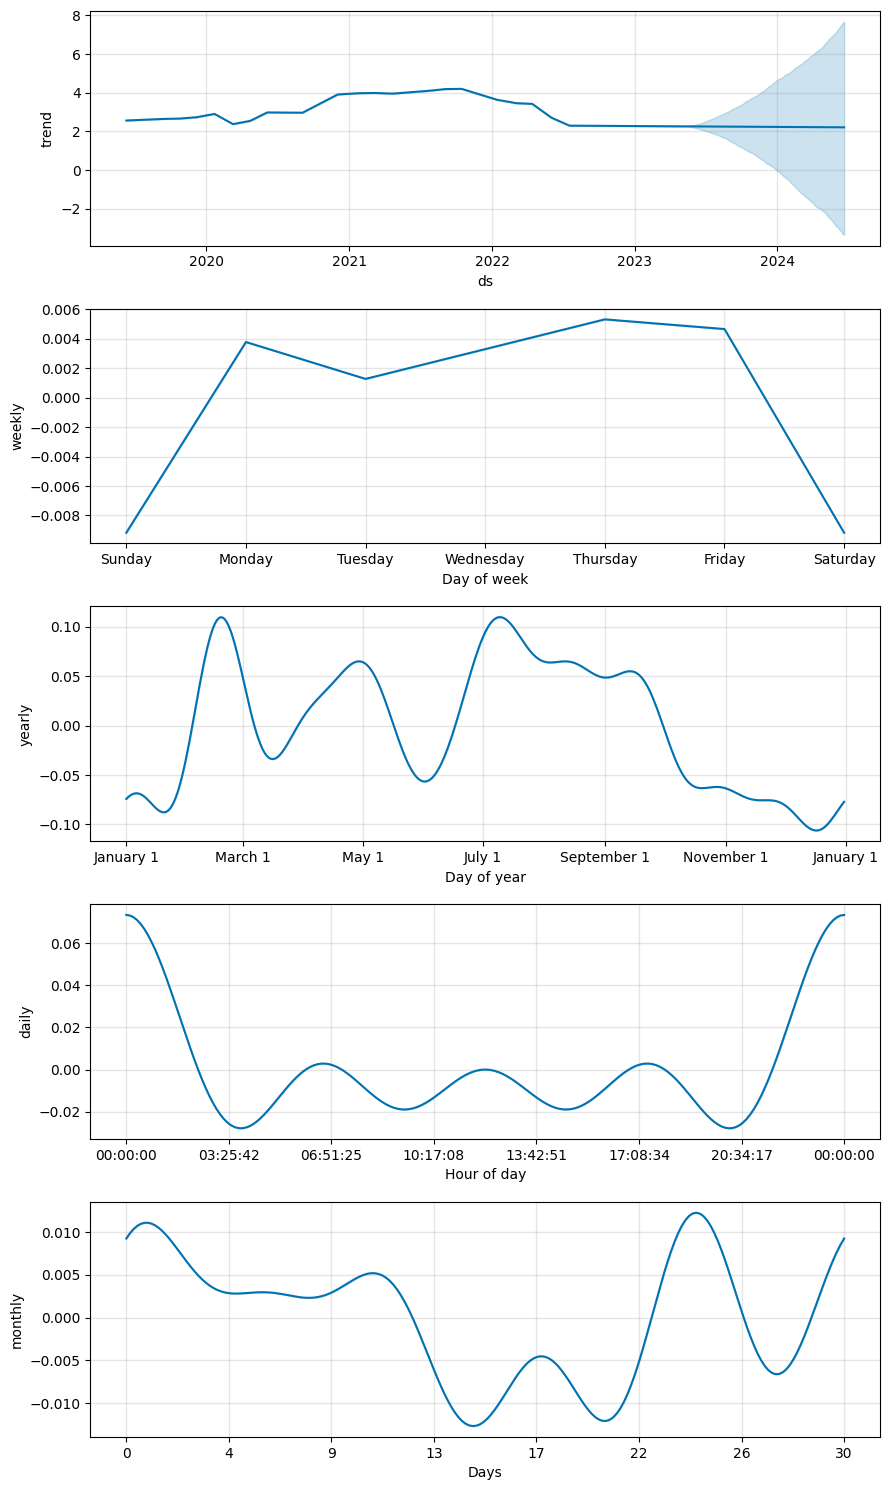

INFO:prophet:Making 33 forecasts with cutoffs between 2020-06-11 00:00:00 and 2023-01-27 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/xb1plac7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/vz13sbgh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14191', 'data', 'file=/tmp/tmpbruor5yw/xb1plac7.json', 'init=/tmp/tmpbruor5yw/vz13sbgh.json', 'output', 'file=/tmp/tmpbruor5yw/prophet_modelx_fzgptp/prophet_model-20250411020425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:04:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:04:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/oo_qr_oe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/tel7ckon.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  9 days  0.012502  0.111811  0.083197  0.025733  0.019040  0.026016   
1 10 days  0.015379  0.124012  0.094220  0.029064  0.020552  0.029441   
2 11 days  0.016629  0.128954  0.099117  0.030632  0.023252  0.031046   
3 12 days  0.018554  0.136214  0.105269  0.032580  0.024944  0.033007   
4 13 days  0.021525  0.146712  0.113892  0.035323  0.026928  0.035872   

   coverage  
0  0.536445  
1  0.479501  
2  0.457665  
3  0.433824  
4  0.416240  


In [48]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import numpy as np

# Load data
snap = pd.read_csv('https://github.com/Kanchan786786/Capstone_project-/raw/main/snapchat_stock_data_features.csv')
df = snap[['Date', 'Close']].copy()
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])

# Log transform
df['y'] = np.log(df['y'])

# Split data
n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.8)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

# Improved Prophet Model
model = Prophet(
    daily_seasonality=True,
    changepoint_prior_scale=0.2  # allow more flexible trend
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # custom seasonality
model.fit(train_df)

# Create future df
future = model.make_future_dataframe(periods=len(val_df) + len(test_df), freq='D')
forecast = model.predict(future)

# Evaluation
forecast_val = forecast.iloc[train_end:val_end][['ds', 'yhat']].set_index('ds')
forecast_test = forecast.iloc[val_end:][['ds', 'yhat']].set_index('ds')
actual_val = val_df.set_index('ds')
actual_test = test_df.set_index('ds')

forecast_val['yhat'] = np.exp(forecast_val['yhat'])
forecast_test['yhat'] = np.exp(forecast_test['yhat'])
actual_val['y'] = np.exp(actual_val['y'])
actual_test['y'] = np.exp(actual_test['y'])

# Scores
val_r2 = r2_score(actual_val['y'], forecast_val['yhat'])
val_mse = mean_squared_error(actual_val['y'], forecast_val['yhat'])
test_r2 = r2_score(actual_test['y'], forecast_test['yhat'])
test_mse = mean_squared_error(actual_test['y'], forecast_test['yhat'])

print(f"[IMPROVED] Validation R-squared: {val_r2:.4f}")
print(f"[IMPROVED] Validation MSE: {val_mse:.4f}")
print(f"[IMPROVED] Testing R-squared: {test_r2:.4f}")
print(f"[IMPROVED] Testing MSE: {test_mse:.4f}")

# Component plot
model.plot_components(forecast)
plt.tight_layout()
plt.show()

# Cross-validation
df_cv = cross_validation(model, initial='365 days', period='30 days', horizon='90 days')
df_perf = performance_metrics(df_cv)
print(df_perf.head())

# --- END OF IMPROVED VERSION ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/xvn6bbvi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/ah61nq9c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41527', 'data', 'file=/tmp/tmpbruor5yw/xvn6bbvi.json', 'init=/tmp/tmpbruor5yw/ah61nq9c.json', 'output', 'file=/tmp/tmpbruor5yw/prophet_modelkjmri1s1/prophet_model-20250411020526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:05:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:05:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-49-6283dbaadcc5>:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future[['Volume', 'RSI', 'MACD']] = future[['Volume', 'RSI', 'MACD']

[THIRD MODEL] Validation R²: -0.6517
[THIRD MODEL] Testing R²: -3.6752


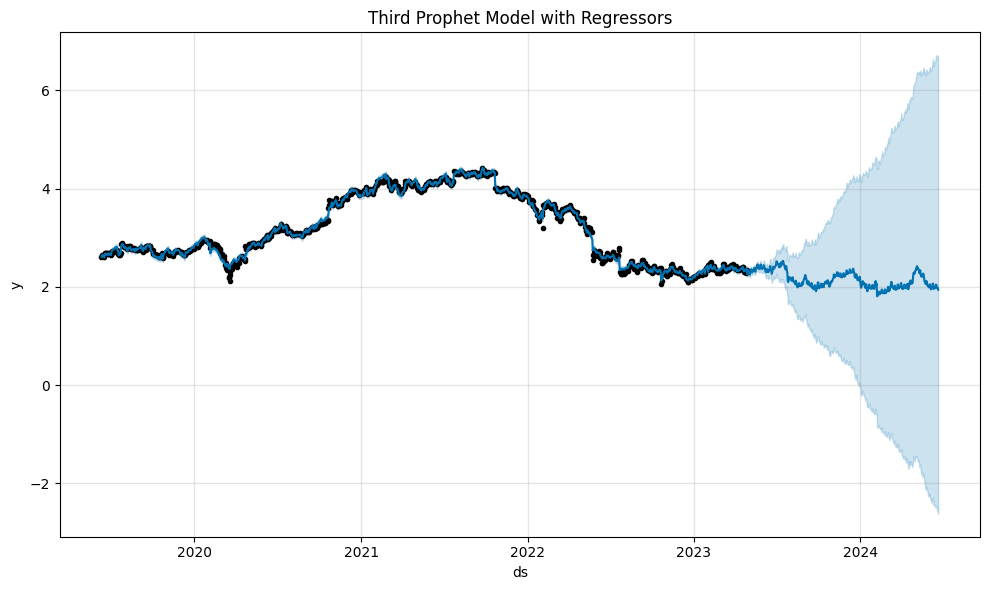

In [49]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# --- THIRD PROPHET MODEL (Advanced Strategy with Regressors + Seasonality) ---

# Step 1: Load and clean data
snap_df = pd.read_csv('https://github.com/Kanchan786786/Capstone_project-/raw/main/snapchat_stock_data_features.csv')
df3 = snap_df.copy()
df3 = df3.iloc[1:].copy()  # Remove invalid first row
df3['Date'] = pd.to_datetime(df3['Date'])

# Convert relevant columns to numeric
for col in ['Close', 'Open', 'Low', 'High', 'Volume']:
    df3[col] = pd.to_numeric(df3[col], errors='coerce')

df3.dropna(subset=['Date', 'Close', 'Volume', 'RSI', 'MACD'], inplace=True)
df3 = df3.sort_values('Date').reset_index(drop=True)

# Step 2: Prepare data for Prophet
prophet_df = df3[['Date', 'Close', 'Volume', 'RSI', 'MACD']].copy()
prophet_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Log transform the target
prophet_df['y'] = np.log(prophet_df['y'])

# Step 3: Split into train, validation, and test
n = len(prophet_df)
train_end = int(n * 0.7)
val_end = int(n * 0.8)

train_df = prophet_df.iloc[:train_end]
val_df = prophet_df.iloc[train_end:val_end]
test_df = prophet_df.iloc[val_end:]

# Step 4: Define the Prophet model
model = Prophet(
    daily_seasonality=False,
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.2
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_regressor('Volume')
model.add_regressor('RSI')
model.add_regressor('MACD')

# Step 5: Fit the model
model.fit(train_df)

# Step 6: Forecast
future = model.make_future_dataframe(periods=len(val_df) + len(test_df), freq='D')
future = future.merge(prophet_df[['ds', 'Volume', 'RSI', 'MACD']], on='ds', how='left')

# ✅ Fill missing regressor values with forward fill to avoid NaNs
future[['Volume', 'RSI', 'MACD']] = future[['Volume', 'RSI', 'MACD']].fillna(method='ffill')

# Make predictions
forecast = model.predict(future)

# Step 7: Evaluation
forecast_val = forecast.iloc[train_end:val_end].set_index('ds')
forecast_test = forecast.iloc[val_end:].set_index('ds')
actual_val = val_df.set_index('ds')
actual_test = test_df.set_index('ds')

forecast_val['yhat'] = np.exp(forecast_val['yhat'])
forecast_test['yhat'] = np.exp(forecast_test['yhat'])
actual_val['y'] = np.exp(actual_val['y'])
actual_test['y'] = np.exp(actual_test['y'])

val_r2 = r2_score(actual_val['y'], forecast_val['yhat'])
test_r2 = r2_score(actual_test['y'], forecast_test['yhat'])

print(f"[THIRD MODEL] Validation R²: {val_r2:.4f}")
print(f"[THIRD MODEL] Testing R²: {test_r2:.4f}")

# Step 8: Plot forecast
model.plot(forecast)
plt.title("Third Prophet Model with Regressors")
plt.tight_layout()
plt.show()


In [50]:
!pip install fbprophet
!pip install yfinance

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.1 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached httpstan-4.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pysimdjson-6.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached crashtest-0.3.1-py3-none-any.whl.metadata (748 bytes)
  Using cached pastel-0.2.1-py2.py3-none-any.whl.metadata (1.9 kB)

In [51]:
import matplotlib.pyplot as plt                                                 #Importing matplotlib to plot and analyse data.
import pandas as pd
import plotly.express as px
from pandas import read_csv                                                  #Importing prophet (prediction and forecasting library.)
import yfinance as yf

In [52]:
import yfinance as yf
import pandas as pd
import plotly.express as px

# Step 1: Download data
df_Vi = yf.download('SNAP', start='2019-01-01', end='2024-12-31')

# Step 2: Reset index
df_Vi.reset_index(inplace=True)

# Step 3: Extract clean Series manually (not from DataFrame column directly)
date_col = df_Vi['Date'].values.ravel()      # 1D array
close_col = df_Vi['Close'].values.ravel()    # ✅ Converts (1509, 1) → (1509,)

# Step 4: Plot using flat arrays
fig = px.line(x=date_col, y=close_col, title='Snapchat Stock Price Over Time', labels={'x': 'Date', 'y': 'Close'})
fig.update_xaxes(rangeslider_visible=True)
fig.show()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [53]:
df_Vi[['ds','y']] = df_Vi[['Date','Close']]                       #preparing expected column names
df_Vi

Price,Date,Close,High,Low,Open,Volume,ds,y
Ticker,,SNAP,SNAP,SNAP,SNAP,SNAP,,
0,2019-01-02,5.79,5.870,5.350,5.380,15253400,2019-01-02,5.79
1,2019-01-03,5.68,5.870,5.630,5.670,16429200,2019-01-03,5.68
2,2019-01-04,5.95,5.990,5.630,5.670,18200400,2019-01-04,5.95
3,2019-01-07,6.21,6.210,5.920,6.000,14726200,2019-01-07,6.21
4,2019-01-08,6.40,6.450,6.210,6.300,16035400,2019-01-08,6.40
...,...,...,...,...,...,...,...,...
1504,2024-12-23,11.26,11.590,11.000,11.525,37248300,2024-12-23,11.26
1505,2024-12-24,11.18,11.280,11.120,11.270,7892400,2024-12-24,11.18
1506,2024-12-26,11.20,11.380,11.070,11.110,12813800,2024-12-26,11.20


In [54]:
train_data = df_Vi.sample(frac=0.8, random_state=0)
test_data = df_Vi.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (1207, 8)
testing data size : (302, 8)


In [55]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
# STEP 2: Split the data
n = len(df_Vi)
train_end = int(n * 0.7)
val_end = int(n * 0.8)

train_data = df_Vi.iloc[:train_end]
test_data = df_Vi.iloc[val_end:]

# STEP 3: Train the model
model = Prophet(daily_seasonality=False,weekly_seasonality=False,holidays_prior_scale=5)
model.fit(train_data)

# STEP 4: Create future dataframe with only test dates
future = pd.DataFrame({'ds': test_data['ds']})

# STEP 5: Make prediction for test period
prediction = model.predict(future)

# STEP 6: Extract actual and predicted
y_actual = test_data['y']
y_predicted = prediction['yhat']

# If y was log-transformed, apply inverse
y_actual = np.exp(y_actual)
y_predicted = np.exp(y_predicted)

# STEP 7: Evaluate
mae = mean_absolute_error(y_actual, y_predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/s0wsrz_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/0_twiszs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5251', 'data', 'file=/tmp/tmpbruor5yw/s0wsrz_j.json', 'init=/tmp/tmpbruor5yw/0_twiszs.json', 'output', 'file=/tmp/tmpbruor5yw/prophet_modelhi4noocw/prophet_model-20250411020558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:05:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:05:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error (MAE): 4169209.36


In [56]:
r2 = r2_score(y_actual, y_predicted)
print(f"📈 R-squared (R²): {r2:.4f}")


📈 R-squared (R²): -0.3119


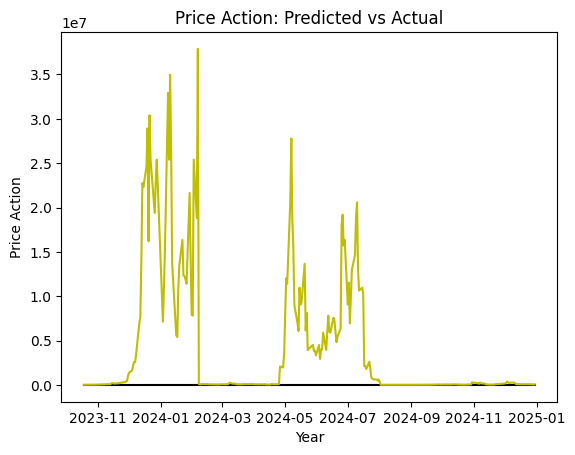

In [57]:
plt.plot(test_data['ds'], y_predicted, 'k')
plt.plot(test_data['ds'], y_actual, 'y')
plt.xlabel("Year")
plt.ylabel("Price Action")
plt.title("Price Action: Predicted vs Actual")
plt.show()

[*********************100%***********************]  1 of 1 completed
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/jww4_0t2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/w9395ay3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22383', 'data', 'file=/tmp/tmpbruor5yw/jww4_0t2.json', 'init=/tmp/tmpbruor5yw/w9395ay3.json', 'output', 'file=/tmp/tmpbruor5yw/prophet_modelsu7w10h5/prophet_model-20250411020600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:06:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:06:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2024-07-04 00:00:00 and 2024-10-02 00:00:00


🔍 In-Sample Training Metrics:
MAPE: 3.94%, RMSE: 0.68, MAE: 0.49


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/ddmunoqn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/gwn9bcvs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49506', 'data', 'file=/tmp/tmpbruor5yw/ddmunoqn.json', 'init=/tmp/tmpbruor5yw/gwn9bcvs.json', 'output', 'file=/tmp/tmpbruor5yw/prophet_modeljbdc3afy/prophet_model-20250411020600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:06:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:06:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/uwzc5e9u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbruor5yw/zzzvnp2e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/


📊 Cross-Validation Metrics (First 5):
  horizon      mape       rmse        mae
0  9 days  0.449412   6.356581   5.075164
1 10 days  0.540946   7.349385   5.897614
2 11 days  0.701896   9.568682   7.741468
3 12 days  0.885451  12.036661   9.918947
4 13 days  1.088600  14.486383  12.165173
⚠️ Model may be overfitting (CV MAPE >> Train MAPE)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



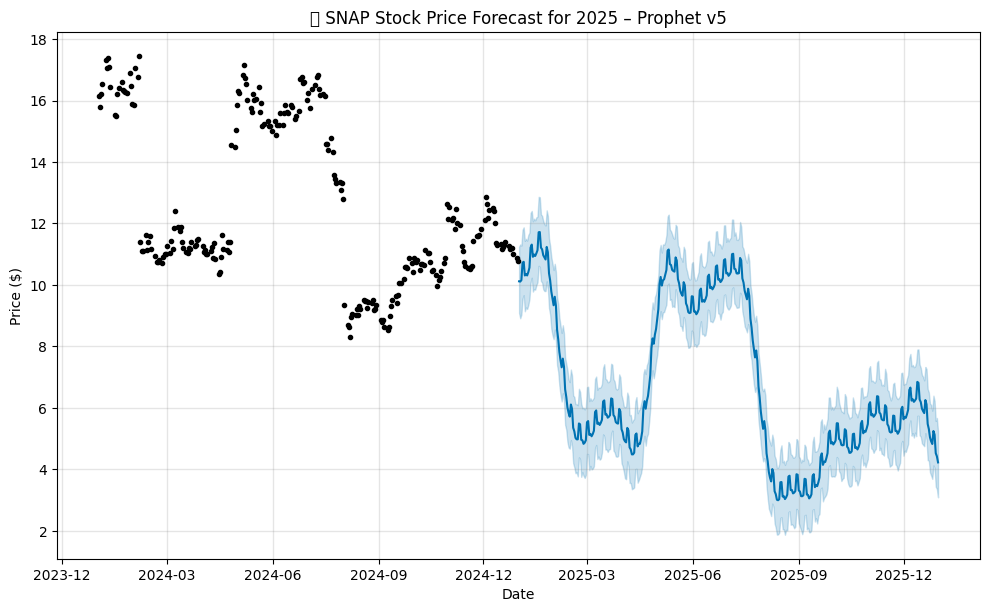


📅 Forecast Summary (Last 5 Days):
            ds      yhat  yhat_lower  yhat_upper
612 2025-12-27  5.246569    4.127268    6.396687
613 2025-12-28  5.125537    4.043731    6.228716
614 2025-12-29  4.526101    3.436794    5.573298
615 2025-12-30  4.422073    3.359327    5.672463
616 2025-12-31  4.225040    3.089724    5.234004


In [58]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 1: Download stock data
ticker = "SNAP"
df = yf.download(ticker, start="2024-01-01", end="2025-01-01", auto_adjust=True)
if df.empty:
    raise Exception("No data found.")

# Step 2: Prepare for Prophet
if isinstance(df.columns, pd.MultiIndex):
    df = df.xs(ticker, axis=1, level='Ticker')
df.reset_index(inplace=True)
df_prophet = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')
if df_prophet['y'].isnull().any():
    raise Exception("Missing values in target (y).")

# Step 3: Build Prophet Model (optimized)
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,
    interval_width=0.90
)
model.add_seasonality(name='weekly_custom', period=7, fourier_order=3)
model.add_seasonality(name='yearly_custom', period=365.25, fourier_order=10)

model.fit(df_prophet)

# Step 4: In-sample error
forecast_train = model.predict(df_prophet)
y_true = df_prophet['y'].values
y_pred = forecast_train['yhat'].values
train_mape = np.mean(np.abs((y_true - y_pred) / y_true))
train_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
train_mae = mean_absolute_error(y_true, y_pred)

print("🔍 In-Sample Training Metrics:")
print(f"MAPE: {train_mape:.2%}, RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}")

# Step 5: Cross-validation
df_cv = cross_validation(model, initial='180 days', period='30 days', horizon='90 days')
df_metrics = performance_metrics(df_cv)
print("\n📊 Cross-Validation Metrics (First 5):")
print(df_metrics[['horizon', 'mape', 'rmse', 'mae']].head())

# Optional: Overfitting check
cv_mape_mean = df_metrics['mape'].mean()
if cv_mape_mean > 1.5 * train_mape:
    print("⚠️ Model may be overfitting (CV MAPE >> Train MAPE)")

# Step 6: Future forecast
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
forecast_2025 = forecast[forecast['ds'].dt.year == 2025]

# Step 7: Plot
fig = model.plot(forecast_2025)
plt.title("📈 SNAP Stock Price Forecast for 2025 – Prophet v5")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.show()

# Final output
print("\n📅 Forecast Summary (Last 5 Days):")
print(forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


In [59]:
from sklearn.metrics import r2_score, mean_squared_error

In [60]:
from sklearn.metrics import r2_score

# Step 6.5: Evaluate Testing Error on last 90 days of available data
# Create test set (last 90 days of historical data)
test_start_date = df_prophet['ds'].max() - pd.Timedelta(days=90)
df_test = df_prophet[df_prophet['ds'] >= test_start_date]

# Get forecasted values for the same dates
forecast_test = forecast[forecast['ds'].isin(df_test['ds'])]

# Align predictions with actuals
y_test_true = df_test.set_index('ds').loc[forecast_test['ds']]['y'].values
y_test_pred = forecast_test['yhat'].values

# Calculate metrics
test_r2 = r2_score(y_test_true, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
test_mae = mean_absolute_error(y_test_true, y_test_pred)
test_mape = np.mean(np.abs((y_test_true - y_test_pred) / y_test_true))

print("\n🧪 Testing Metrics (Last 90 Days of 2024):")
print(f"R²: {test_r2:.4f}, RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2%}")



🧪 Testing Metrics (Last 90 Days of 2024):
R²: 0.4524, RMSE: 0.54, MAE: 0.45, MAPE: 3.99%


## SVM

In [61]:
pip install keras-tuner

In [62]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split

In [63]:
snap=pd.read_csv(r'https://github.com/Kanchan786786/Capstone_project-/raw/main/snapchat_stock_data_features.csv')
snap.head()

,Date,Close,Tomorrow,Low,Open,Volume,VWAP,Adjusted_Close,Market_Cap,SMA_50,EMA_50,RSI,MACD,MACD_Signal,MACD_Hist,High
0,2019-06-10,13.77,13.54,13.695,13.95,25589800,11.725121,13.77,352371557.7,11.6144,11.716234,72.124297,0.607705,0.335428,0.272277,14.07
1,2019-06-11,13.54,13.75,13.385,13.93,21898000,11.754604,13.54,296498919.2,11.6648,11.787754,68.106898,0.631566,0.394656,0.236910,13.97
2,2019-06-12,13.75,14.11,13.477,13.71,17515800,11.778810,13.75,240842250.0,11.7126,11.864705,69.762965,0.659815,0.447688,0.212127,13.98
3,2019-06-13,14.11,13.96,13.750,13.85,25003000,11.817858,14.11,352792321.4,11.7704,11.952756,72.408001,0.703146,0.498779,0.204367,14.31
4,2019-06-14,13.96,13.55,13.650,14.15,24189700,11.852153,13.96,337688212.9,11.8264,12.031471,69.673169,0.717116,0.542447,0.174669,14.15


In [64]:
snap['Date']=pd.to_datetime(snap['Date'])

In [65]:
snap.set_index('Date', inplace=True)


In [66]:
snap.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1399 entries, 2019-06-10 to 2024-12-27
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           1399 non-null   float64
 1   Tomorrow        1399 non-null   float64
 2   Low             1399 non-null   float64
 3   Open            1399 non-null   float64
 4   Volume          1399 non-null   int64  
 5   VWAP            1399 non-null   float64
 6   Adjusted_Close  1399 non-null   float64
 7   Market_Cap      1399 non-null   float64
 8   SMA_50          1399 non-null   float64
 9   EMA_50          1399 non-null   float64
 10  RSI             1399 non-null   float64
 11  MACD            1399 non-null   float64
 12  MACD_Signal     1399 non-null   float64
 13  MACD_Hist       1399 non-null   float64
 14  High            1399 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 174.9 KB


In [67]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR  # Import the SVM Regressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

features = ['High', 'Low', 'Open','Adjusted_Close', 'Market_Cap', 'SMA_50', 'EMA_50']
target = 'Close'
# Split the data into training (80%) and testing (20%) sets
train, test = train_test_split(snap, test_size=0.2, random_state=1, shuffle=False)

# Initialize the SVM model (SVR for regression) without scaling
svm_model = SVR(kernel="rbf", C=1.0, gamma="scale")

# Train the SVM model
svm_model.fit(train[features], train[target])

# Predict on training and testing sets
#train_preds = svm_model.predict(train[features])
test_preds = svm_model.predict(test[features])

# Calculate R-squared and Mean Squared Error (MSE)
#train_r2 = r2_score(train[target], train_preds)
test_r2 = r2_score(test[target], test_preds)
#train_mse = mean_squared_error(train[target], train_preds)
test_mse = mean_squared_error(test[target], test_preds)

# Print results
#print(f"Training R-squared: {train_r2:.4f}")
print(f"Testing R-squared: {test_r2:.4f}")
#print(f"Training Mean Squared Error: {train_mse:.4f}")
print(f"Testing Mean Squared Error: {test_mse:.4f}")

Testing R-squared: -7.5982
Testing Mean Squared Error: 60.1743


## this model is not performaing well with base model
second SVM is with MinMAx scaler



In [68]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR  # Import the SVM Regressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

features = ['High', 'Low', 'Open','Adjusted_Close', 'Market_Cap', 'SMA_50', 'EMA_50']
target = 'Close'
# Normalize data using MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(snap[features + [target]]), columns=features + [target],index=snap.index)
# Split the data into training (80%) and testing (20%) sets
train, test = train_test_split(df_scaled, test_size=0.2, random_state=1, shuffle=False)

# Initialize the SVM model (SVR for regression) without scaling
svm_model_2 = SVR(kernel="rbf", C=1.0, gamma="scale")

# Train the SVM model
svm_model_2.fit(train[features], train[target])

# Predict on training and testing sets
#train_preds = svm_model.predict(train[features])
test_preds = svm_model_2.predict(test[features])

# Calculate R-squared and Mean Squared Error (MSE)
#train_r2 = r2_score(train[target], train_preds)
test_r2 = r2_score(test[target], test_preds)
#train_mse = mean_squared_error(train[target], train_preds)
test_mse = mean_squared_error(test[target], test_preds)

# Print results
#print(f"Training R-squared: {train_r2:.4f}")
print(f"Testing R-squared: {test_r2:.4f}")
#print(f"Training Mean Squared Error: {train_mse:.4f}")
print(f"Testing Mean Squared Error: {test_mse:.4f}")


Testing R-squared: -0.7512
Testing Mean Squared Error: 0.0022


##Comparison of the two SVM we can see the scaled one provide the better results
Next we have the next approach where we will take the next approach with taking three parts and

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'svr__C': 10, 'svr__epsilon': 0.1, 'svr__gamma': 0.01}
Final Test R²: 0.9594
Final Test MSE: 0.2839


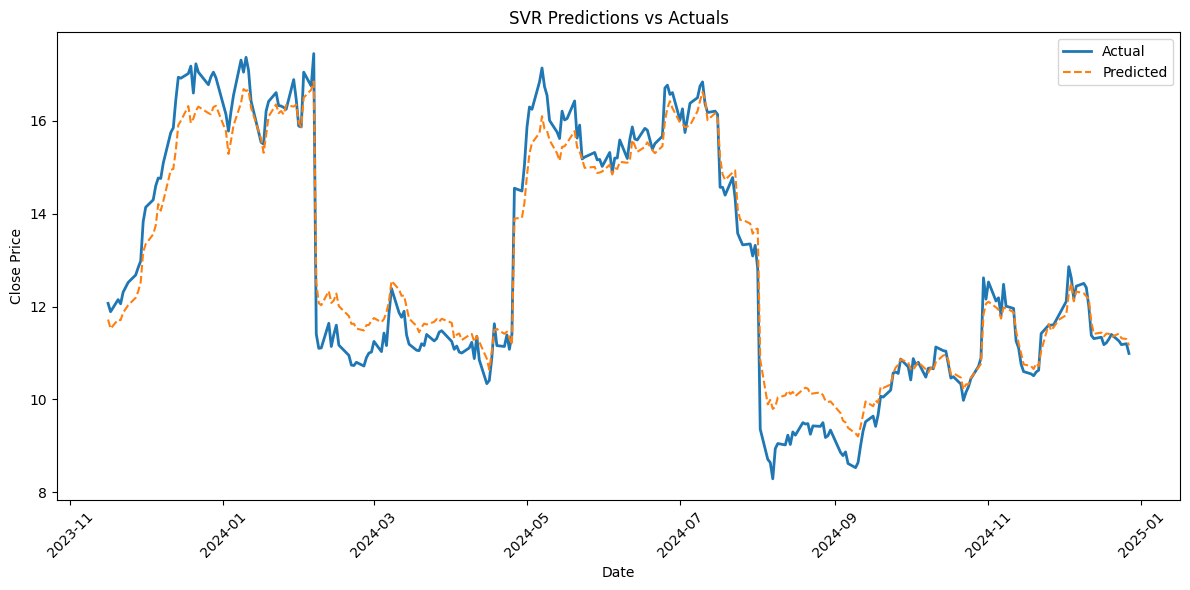

In [69]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# --- Load & Prepare Data ---a
# Ensure Date column is datetime
# Drop the 'Tomorrow' column if it leaks future info
features = ['High', 'Low', 'Open', 'Adjusted_Close', 'SMA_50', 'EMA_50']
target = 'Close'

# --- Time-based Split: 60% Train / 20% Validation / 20% Test ---
total_len = len(snap)
train_end = int(total_len * 0.6)
val_end = int(total_len * 0.8)

train_df = snap.iloc[:train_end]
val_df = snap.iloc[train_end:val_end]
test_df = snap.iloc[val_end:]

# Combine Train + Validation for tuning
combined_train_val = pd.concat([train_df, val_df])

# --- Define Pipeline: Scaling + SVR ---
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svr', SVR())
])

# --- Define Parameter Grid for Hypertuning ---
param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__gamma': ['scale', 0.01, 0.1],
    'svr__epsilon': [0.1, 0.2, 0.3]
}

# --- Use TimeSeriesSplit for Cross-Validation ---
tscv = TimeSeriesSplit(n_splits=5)

# --- GridSearchCV on Train + Validation ---
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(combined_train_val[features], combined_train_val[target])

# --- Evaluate Best Model ---
best_model = grid_search.best_estimator_

# Predict on Test Set
test_preds = best_model.predict(test_df[features])

# Metrics
test_r2 = r2_score(test_df[target], test_preds)
test_mse = mean_squared_error(test_df[target], test_preds)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Final Test R²: {test_r2:.4f}")
print(f"Final Test MSE: {test_mse:.4f}")

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df[target], label='Actual', linewidth=2)
plt.plot(test_df.index, test_preds, label='Predicted', linestyle='--')
plt.title('SVR Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Model Summary for the company Snapchat


| Model                     | Type | Layers/Params                    | Activation Function | Dropout Used | Dropout Rate       | Epochs |  Test Accuracy Range | Tuning Method for improvement           | Key Notes                                       | Outcome                              |
|:------------------------:|:----:|:--------------------------------:|:-------------------:|:------------:|:------------------:|:------:|:---------------:|:------------------------:|:-----------------------------------------------:|:------------------------------------:|
| LSTM with BayesianOptimization|DL | D50/LSTM_Layer2   | ReLU                | Y            | 0.2 / both layers  | 30   |-0.2286 to   0.68708888 ,0.775157     | Bayesian Optimization     | Moderate improvement, still below Random Search | Slight improvement     and random serach
              |
| ARIMA                    | TS   | p,d,q (default)                  | N/A                 | N            | N/A                | N/A    |  -0.1374244300   | Random Search           | Non-stationary data; needs differencing         | Try stationarizing data              |
| SARIMA                   | TS   | (p,d,q)(P,D,Q,s)                 | N/A                 | N            | N/A                | N/A    | -0.266487648     | Random Search           | Captures seasonality but suffered overfitting   | Overfitting with seasonal terms      |
| Prophet                 | TS   | Additive Components              | N/A                 | N            | N/A                | N/A    |  -4.9700   to 0.4567      | basic serach with the  ,cross validation,           | Easy to implement; severe overfitting           | performanced worst at the bse line , with improvised and cross validation step improved .   |
| SVM                      | ML   | Kernel=RBF, C=1                  | N/A                 | N            | N/A                | N/A    | range is -7.6 to 0.95           | Random Search (gamma=0.01) | Excellent accuracy, classic model | Best accuracy but still scope to improvised    |
